In [1]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy import units as u
import sncosmo

from mcmc_tools_tess import *
from useful_functions import lcImport

In [2]:
ab = sncosmo.get_magsystem('ab')
tess_response = pd.read_csv('./tess_response_curve.csv',header=0,names=['wl_nm','trans'])
tess_response['wl_ang'] = (np.array(tess_response['wl_nm']) * u.nm).to_value('angstrom')

atlaso_response = pd.read_csv('./atlas_o.csv',header=0,names=['wl_ang','trans'])

sn2020bpi_ztf = pd.read_csv('./sn2020bpi_ztf.csv',header=0)
sn2020bpi_ztf['BTJD'] = Time(sn2020bpi_ztf['mjd'],format='mjd').jd - 2457000.0
sn2020bpi_ztf['magap_rolling'] = sn2020bpi_ztf['magap'].rolling(12).median()
sn2020bpi_ztf['flux'] = [ab.band_mag_to_flux(sn2020bpi_ztf['magap'][i], 'ztfr') for i in range(len(sn2020bpi_ztf['magap']))]
sn2020bpi_ztf['flux_rolling'] = sn2020bpi_ztf['flux'].rolling(12).median()

In [3]:
sn2020bpi_s21_dir = './Fausnaugh/sector21/cam3_ccd2/lc/lc_2020bpi_cleaned'
sn2020bpi_s21 = lcImport(sn2020bpi_s21_dir)
sn2020bpi_s21['cts_median'] = sn2020bpi_s21['cts'].rolling(24).median()
sn2020bpi_s21['e_cts_median'] = sn2020bpi_s21['e_cts'].rolling(24).median()
sn2020bpi_s21['mjd'] = Time(sn2020bpi_s21['BTJD']+2457000.0, format='jd').mjd

sn2020bpi_s22_dir = './Fausnaugh/sector22/cam3_ccd1/lc/lc_2020bpi_cleaned'
sn2020bpi_s22 = lcImport(sn2020bpi_s22_dir)
sn2020bpi_s22['cts_median'] = sn2020bpi_s22['cts'].rolling(24).median()
sn2020bpi_s22['e_cts_median'] = sn2020bpi_s22['e_cts'].rolling(24).median()
sn2020bpi_s22['mjd'] = Time(sn2020bpi_s22['BTJD']+2457000.0, format='jd').mjd

sn2020bpi_s22_fix = (1912,1914.5)
sn2020bpi_s22_fixed = sn2020bpi_s22.query('BTJD > 1900')
sn2020bpi_s22_fixed = sn2020bpi_s22_fixed[(sn2020bpi_s22_fixed['BTJD'] < sn2020bpi_s22_fix[0]) | (sn2020bpi_s22_fixed['BTJD'] > sn2020bpi_s22_fix[1])]

sn2020bpi_s21s22 = pd.concat([sn2020bpi_s21,sn2020bpi_s22_fixed])
sn2020bpi_s21s22['cts_bkg_model_sub'] = sn2020bpi_s21s22['cts'] - sn2020bpi_s21s22['bkg_model']

In [4]:
tess_start_mjd = sn2020bpi_s21s22['mjd'].min()
tess_end_mjd = sn2020bpi_s21s22['mjd'].max()
sn2020bpi_ztf_r = sn2020bpi_ztf.query('fid == 2 & mjd > @tess_start_mjd & mjd < @tess_end_mjd').reset_index()

In [5]:
sn2020bpi_ztf_r.keys()

Index(['index', 'candid_str', 'oid', 'candid', 'mjd', 'fid', 'diffmaglim',
       'magpsf', 'magap', 'sigmapsf', 'sigmagap', 'ra', 'dec', 'sigmara',
       'sigmadec', 'isdiffpos', 'distpsnr1', 'sgscore1', 'field', 'rcid',
       'magnr', 'sigmagnr', 'rb', 'magpsf_corr', 'magap_corr', 'sigmapsf_corr',
       'sigmagap_corr', 'has_stamps', 'parent_candid', 'BTJD', 'magap_rolling',
       'flux', 'flux_rolling'],
      dtype='object')

In [6]:
tess_2020bpi = pd.read_csv('JhaData/TESS_SN2020bpi.csv')
tess_2020bpi.head()

,BTJD,mjd,cts,e_cts,bkg_model,raw_flux,e_flux,bkg_model_flux,corr_flux
0,1870.44408,58869.94408,-5339.0302,1368.8706,1502.1435,-0.030663,0.007862,0.008627,0.002060
1,1870.44408,58869.94408,-5334.2775,1367.3354,1502.1435,-0.030636,0.007853,0.008627,0.002085
2,1870.46491,58869.96491,-6841.1413,1375.3282,1502.1435,-0.039290,0.007899,0.008627,-0.006033
3,1870.46491,58869.96491,-6820.1378,1373.8129,1502.1435,-0.039169,0.007890,0.008627,-0.005920
4,1870.48574,58869.98574,-2219.7583,1400.7610,1501.2344,-0.012748,0.008045,0.008622,0.018870


In [7]:
ztf_2020bpi = pd.read_csv('JhaData/ztf_SN2020bpi.csv')
ztf_2020bpi['flux_err'] = 0.008*np.ones(len(ztf_2020bpi))
ztf_2020bpi.head()

,BTJD,mjd,magap,sig_magap,flux,flux_err
0,1879.870567,58879.370567,19.729799,0.2218,0.014224,0.008
1,1881.011065,58880.511065,19.959801,0.2436,0.011509,0.008
2,1881.031343,58880.531343,19.473101,0.1538,0.018018,0.008
3,1881.843854,58881.343854,19.660400,0.2291,0.015163,0.008
4,1882.032546,58881.532546,19.363001,0.1425,0.019941,0.008


In [8]:
tess_2020bpi.rename(columns={'raw_flux':'flux','e_flux':'flux_err'},inplace=True)
tess_2020bpi.head()

,BTJD,mjd,cts,e_cts,bkg_model,flux,flux_err,bkg_model_flux,corr_flux
0,1870.44408,58869.94408,-5339.0302,1368.8706,1502.1435,-0.030663,0.007862,0.008627,0.002060
1,1870.44408,58869.94408,-5334.2775,1367.3354,1502.1435,-0.030636,0.007853,0.008627,0.002085
2,1870.46491,58869.96491,-6841.1413,1375.3282,1502.1435,-0.039290,0.007899,0.008627,-0.006033
3,1870.46491,58869.96491,-6820.1378,1373.8129,1502.1435,-0.039169,0.007890,0.008627,-0.005920
4,1870.48574,58869.98574,-2219.7583,1400.7610,1501.2344,-0.012748,0.008045,0.008622,0.018870


sampling...
done
CPU times: user 7min 30s, sys: 281 ms, total: 7min 30s
Wall time: 7min 30s


array([[5.88336210e+04, 1.85018135e-06, 4.02914792e-02],
       [5.88336449e+04, 1.84992371e-06, 4.02908347e-02],
       [5.88362940e+04, 2.12513266e-06, 4.03136649e-02],
       ...,
       [5.88312930e+04, 2.00959531e-06, 4.05949816e-02],
       [5.88318273e+04, 2.03182338e-06, 4.05868184e-02],
       [5.88318273e+04, 2.03182338e-06, 4.05868184e-02]])

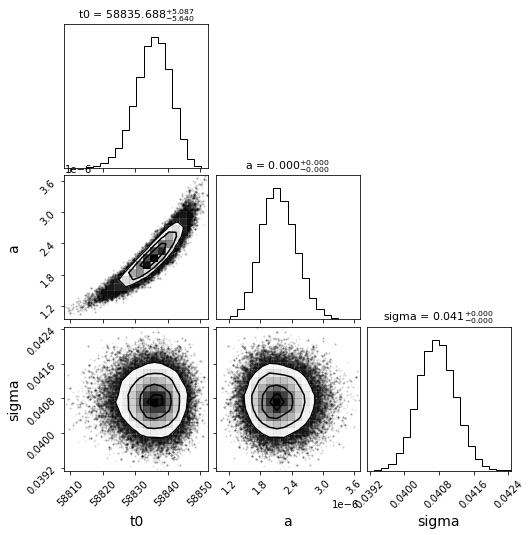

In [9]:
guess = [58872, 2.9e-4, 0.0]
scale = [0.0005, 1e-7, 0.001]
%time doMCMC(tess_2020bpi, guess, scale)

sampling...
done
CPU times: user 6min 52s, sys: 1.46 s, total: 6min 54s
Wall time: 6min 53s


array([[5.87021263e+04, 1.77990039e-06, 2.12660145e-02],
       [5.87021263e+04, 1.77990039e-06, 2.12660145e-02],
       [5.87021263e+04, 1.77990039e-06, 2.12660145e-02],
       ...,
       [5.86603945e+04, 1.24442329e-06, 2.14412384e-02],
       [5.86603945e+04, 1.24442329e-06, 2.14412384e-02],
       [5.86603945e+04, 1.24442329e-06, 2.14412384e-02]])

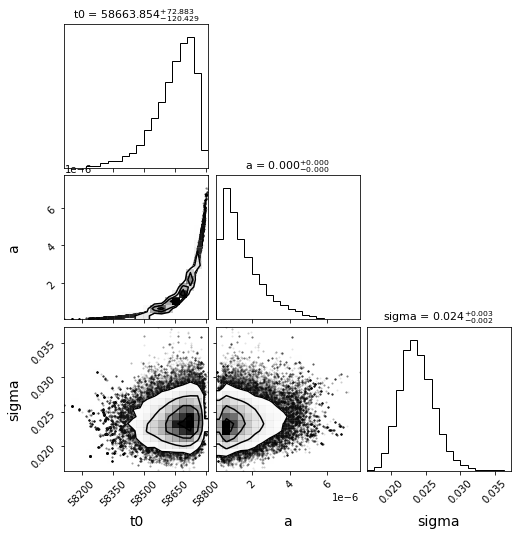

In [10]:
%time doMCMC(ztf_2020bpi, guess, scale)